In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
path = '/home/omarioni/'

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
time_M31gd = M31_gd[:,0]
lbar_M31gd = M31_gd[:,1]

#------------------------------------------------------------------------------------------
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_lbarvstime2.dat')
time_M31gs = M31_gs[:,0]
lbar_M31gs = M31_gs[:,1]

#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_lbarvstime2.dat')
time_MWgs = MW_gs[:,0]
lbar_MWgs = MW_gs[:,1]


In [56]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
from __future__ import unicode_literals
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')


path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]

Path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,50,-1)
for isnap in snapshot:
    snap = h5py.File(Path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,1):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        IDs  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Ids'].value
        mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i]) + '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s' %vector[i]) + '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Masses'].value
        
        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
        ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
        zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
        
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
        mstr = mstr/h
        mgas = mgas/h
        mdrk = mdrk/h

        r200 = r200*aexp[isnap]/h
        rgal = 0.15*r200

        limit = np.where(rstr<rgal)
        r_sort = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])

        Mc_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        cincuenta, = np.where(razon < 0.5)

        r50 = r_sort[cincuenta][-1]              

    #------------------masa total en r200 (Mvir)--------------------------         
        veloc,=np.where(rstr<r50)

    #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        rn = np.sqrt(xn**2 + yn**2)
        Vtg = (-yn*vxn + xn*vyn)/rn
        
#         print VT, len(VT)
#         print rn, len(rn)
#         mask, = [np.where(rn<5.)]
#         xx = xn[mask]
#         yy = yn[mask]
#         zz = zn[mask]
#         ID = IDs[mask]
        
#------------------------------------------------------------------
        rtot = concatenate([rstr, rgas, rdrk])
        mtot = concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
#--------------------------------------------------------------
        med, nodos = bine.rbin1(rn,30)
    
        vtan_mean   = np.zeros(len(med))
        vtan_median = np.zeros(len(med))
        
        for i in range(0,len(med)):
            mask, = np.where((rn>nodos[i])&(rn<nodos[i+1]))
            vtan_mean[i] = np.mean(Vtg[mask])
#             vtan_median[i] = np.median(Vtg[mask])
        
        finterp1 = sint.interp1d(med,vtan_mean)
        omega_circ= Vtot/rtot_sort
        omega = finterp1(lbar_M31gd[496-isnap])/med
        omega_bar = finterp1(lbar_M31gd[496-isnap])/lbar_M31gd[496-isnap]
#         print omega_bar

        finterp2 = sint.interp1d(omega_circ,rtot_sort)
        rcorot = finterp2(omega_bar)
            
#--------------------------------------------------------------------
        path = '/home/omarioni/'
    
        archivo =  open(path + 'Barras_GdGs/Barras_Gd/_data/M31_omega_rcorot_vstime.dat','a')
        archivo.write(str('%12.6f'% time) +'\t'+
                    str('%12.6f'% omega_bar) +'\t'+
                    str('%12.6f'% rcorot) +'\n')
        archivo.close()
#-------------------------------------------------------------------------
            
#         finterp = sint.interp1d(med,vtan_mean)
        
#         print finterp(lbar_M31gd[0])
        
#         fig=plt.figure(1,figsize=(8,8))
#         fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
#         ax1=fig.add_subplot(111)
        
#         ax1.plot(rn, Vtg, '.', color='k', markersize=0.5)
# #         ax1.plot(radio, vt, '-', color='k')
#         ax1.plot(med, vtan_mean, '-', color='g')
# #         ax1.plot(med, vtan_median, '-', color='c')
#         ax1.plot(rtot_sort,Vtot,'-', color='r')
#         ax1.axvline(x=lbar_M31gd[0],ymin=0,ymax=200,ls=':',color='k')
# #         ax1.plot(xx[mask1],yy[mask1],'.', markersize=0.5, color='r')
# #         ax1.plot(xx[mask2],yy[mask2],'.', markersize=0.5, color='b')
# #         ax1.plot(x,y,'k--')
#         #plt.axis('off')
#         #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
#         #ax1.set_xticklabels([])
#         #ax1.set_yticklabels([])
#         ax1.set_xlim(0,5)
# #         ax1.set_ylim(0,200)
# #         plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
# #         plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
#         ax1.minorticks_on()
#         ax1.tick_params( labelsize=26)
#         ax1.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
#         ax1.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

#         plt.show()
#         #plt.clf()
        


/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in divide
/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in divide


IndexError: index 196 is out of bounds for axis 0 with size 196

56.1689121104
rcorot= 2.60762359844
1.87136767236


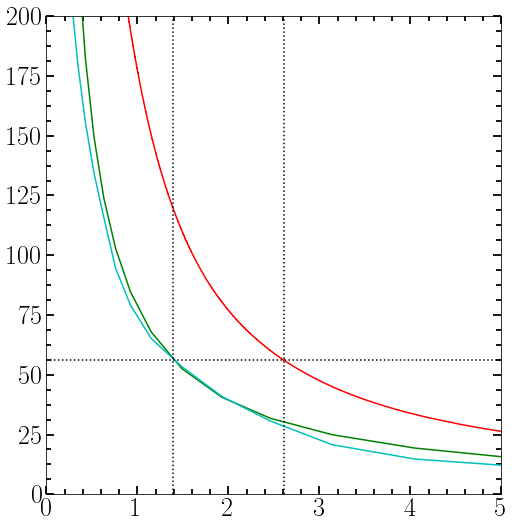

In [51]:
omega_circ= Vtot/rtot_sort
omega = finterp(lbar_M31gd[0])/med
omega_bar = finterp(lbar_M31gd[0])/lbar_M31gd[0]
print omega_bar

finterp2 = sint.interp1d(omega_circ,rtot_sort)
rcorot = finterp2(omega_bar)

print 'rcorot=', rcorot
print rcorot/lbar_M31gd[0]

fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)

#         ax1.plot(rn, Vtg, '.', color='k', markersize=0.5)
#         ax1.plot(radio, vt, '-', color='k')
ax1.plot(med, omega, '-', color='g')
#         ax1.plot(med, vtan_median, '-', color='c')
ax1.plot(rtot_sort,omega_circ,'-', color='r')
ax1.plot(med,vtan_mean/med,'-', color='c')
ax1.axvline(x=lbar_M31gd[0],ymin=0,ymax=200,ls=':',color='k')
ax1.axhline(y=omega_bar,xmin=0,xmax=5,ls=':',color='k')
ax1.axvline(x=rcorot,ymin=0,ymax=200,ls=':',color='k')
#         ax1.plot(xx[mask1],yy[mask1],'.', markersize=0.5, color='r')
#         ax1.plot(xx[mask2],yy[mask2],'.', markersize=0.5, color='b')
#         ax1.plot(x,y,'k--')
#plt.axis('off')
#ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_xlim(0,5)
ax1.set_ylim(0,200)
#         plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
#         plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
ax1.minorticks_on()
ax1.tick_params( labelsize=26)
ax1.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax1.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

plt.show()

In [57]:
path = '/home/omarioni/'

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_omega_rcorot_vstime.dat')
time_M31gd  = M31_gd[:,0]
omega_M31gd = M31_gd[:,1]
rcor_M31gd  = M31_gd[:,2]

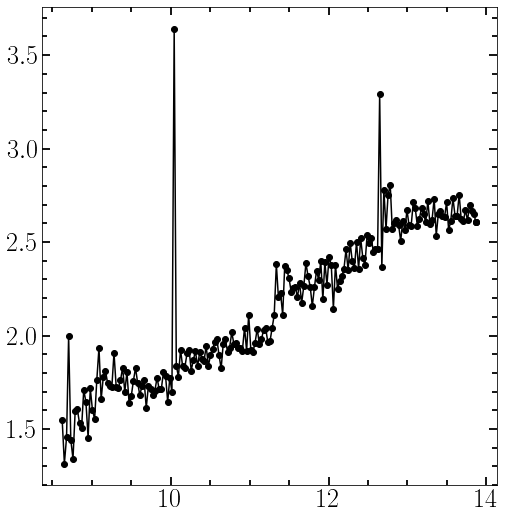

In [60]:
fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(time_M31gd, rcor_M31gd, '-o', color='k')
#         ax1.plot(med, vtan_median, '-', color='c')
# ax1.plot(rtot_sort,omega_circ,'-', color='r')
# ax1.plot(med,vtan_mean/med,'-', color='c')
# ax1.axvline(x=lbar_M31gd[0],ymin=0,ymax=200,ls=':',color='k')
# ax1.axhline(y=omega_bar,xmin=0,xmax=5,ls=':',color='k')
# ax1.axvline(x=rcorot,ymin=0,ymax=200,ls=':',color='k')
#         ax1.plot(xx[mask1],yy[mask1],'.', markersize=0.5, color='r')
#         ax1.plot(xx[mask2],yy[mask2],'.', markersize=0.5, color='b')
#         ax1.plot(x,y,'k--')
#plt.axis('off')
#ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
# ax1.set_xlim(0,5)
# ax1.set_ylim(0,200)
#         plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
#         plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
ax1.minorticks_on()
ax1.tick_params( labelsize=26)
ax1.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax1.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

plt.show()

In [23]:
path='/home/omarioni/Barras_GdGs/Barras_Gd/_data/'
dat = np.loadtxt(path+'j_C_str.dat')
radio = dat[:,0]
vt = dat[:,3]

In [ ]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength2 as strng
from numpy import matrix
import tenform as ten
from numpy import linalg

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

atime = np.loadtxt('/home/ornela/SimCLUES/redshift_outputs.txt')
aexp = atime[:,2]


snapshot=range(496,495,-1) #SNAPSHOTS
i = 0
for isnap in snapshot:
    
    snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.


    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#-----------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
#--------------------------------------------------------------------------------------    

    corte, = np.where(r<3*aexp[isnap])
    
    A2max, rmax, phi = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)
    
    #Hacemos la rotación de las coordenadas
    xx = xn*cos(phi)+yn*sin(phi)
    yy = xn*-sin(phi)+yn*cos(phi)
    zz = zn
    
    
    #----para lbar1--------------------------------------------------------------
    limit1,=np.where(r < lbar1[i])
    tensor = ten.tenf(xx[limit1], yy[limit1], zz[limit1])

    matriz = linalg.eig(tensor)
    autov  = matriz[0]

    asort  = np.sort(autov)

    a1 = asort[2]
    b1 = asort[1]
    c1 = asort[0]

    A1 = np.sqrt(a1)
    B1 = np.sqrt(b1)
    C1 = np.sqrt(c1)

    
#Definimos el tamaño de nuestro elipsoide
    aa=lbar1[i]
    bb=(B1/A1)*lbar1[i]
    cc=(C1/A1)*lbar1[i]
    
#     print 'a=', aa, 'b=', bb, 'c=', cc
    
    RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2) # formula del elipsoide
    mask, = np.where(RR<=1) #seleccionamos las particulas dentro del elipsoide
    
    xn1   = xn[mask]
    yn1   = yn[mask]
    zn1   = zn[mask]
    vxn1  = vxn[mask]
    vyn1  = vyn[mask]
    vzn1  = vzn[mask]
    mstr1 = mstr[mask]
    
    rcil = np.sqrt(xn1**2 + yn1**2)
    
    mask2, = np.where((rcil>0.8*aa) & (rcil<aa)) #tomamos las particulas de la punta del elipsoide

# #Calculamos las componentes de momento angular
#     Lx = sum((yn1[mask2]*vzn1[mask2] - zn1[mask2]*vyn1[mask2]) * mstr1[mask2])
#     Ly = sum((zn1[mask2]*vxn1[mask2] - xn1[mask2]*vzn1[mask2]) * mstr1[mask2])
#     Lz = sum((xn1[mask2]*vyn1[mask2] - yn1[mask2]*vxn1[mask2]) * mstr1[mask2])

# #Calculamos las componentes del tensor de inercia
#     Ixx = sum(mstr1[mask2] * (yn1[mask2]**2 + zn1[mask2]**2))
#     Ixy = sum(mstr1[mask2] * xn1[mask2] * yn1[mask2])
#     Ixz = sum(mstr1[mask2] * xn1[mask2] * zn1[mask2])
#     Iyy = sum(mstr1[mask2] * (xn1[mask2]**2 + zn1[mask2]**2))
#     Iyz = sum(mstr1[mask2] * yn1[mask2] * zn1[mask2])
#     Izz = sum(mstr1[mask2] * (xn1[mask2]**2 + yn1[mask2]**2))
    
#     II = matrix([[Ixx,Ixy,Ixz],[Ixy, Iyy, Iyz], [Ixz, Iyz, Izz]]) #matriz del tensor de inercia
    
#     Iinv = II.I #Invertimos la matriz

#     omega = Iinv[2,0]*Lx +Iinv[2,1]*Ly + Iinv[2,2]*Lz #velocidad angular del elipsoide
    
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
# #Lo mismo que arriba pero usamos todas las particulas del elipsoide

# #Calculamos las componentes de momento angular
#     Lx_total = sum((yn1*vzn1 - zn1*vyn1) * mstr1)
#     Ly_total = sum((zn1*vxn1 - xn1*vzn1) * mstr1)
#     Lz_total = sum((xn1*vyn1 - yn1*vxn1) * mstr1)

# #Calculamos las componentes del tensor de inercia
#     Ixx_total = sum(mstr1 * (yn1**2 + zn1**2))
#     Ixy_total = sum(mstr1 * xn1 * yn1)
#     Ixz_total = sum(mstr1 * xn1 * zn1)
#     Iyy_total = sum(mstr1 * (xn1**2 + zn1**2))
#     Iyz_total = sum(mstr1 * yn1 * zn1)
#     Izz_total = sum(mstr1 * (xn1**2 + yn1**2))
    
#     II_total = matrix([[Ixx_total ,Ixy_total,Ixz_total],
#                        [Ixy_total, Iyy_total, Iyz_total], 
#                        [Ixz_total, Iyz_total, Izz_total]]) #matriz del tensor de inercia
    
#     Iinv_total = II_total.I #Invertimos la matriz

# #velocidad angular del elipsoide
#     omega_total = Iinv_total[2,0]*Lx_total + Iinv_total[2,1]*Ly_total + Iinv_total[2,2]*Lz_total 


# otra forma -----------------------------------------------------------------------------    
#     detI = Ixx*Iyy*Izz + 2*Ixy*Iyz*Ixz - Iyy*Ixz**2 - Ixx*Iyz**2 - Izz*Ixy**2
#     print detI
    
#     a13 = (Ixy*Iyz-Ixz*Iyy)/detI
#     a23 = (Ixz*Ixy-Iyz*Ixx)/detI
#     a33 = (Ixx*Iyy-Ixy**2)/detI
#     print a33
    #omegaz = median(Lz/Izz)
#     print omegaZ
    
#     omega2 = (xn[mask]*vyn[mask] - yn[mask]*vxn[mask])/rcil[mask]**2
#     omega3 = median(omega2)
    
#     VT =(xn[mask]*vyn[mask] - yn[mask]*vxn[mask])/rcil[mask]
#--------------------------------------------------------------------------------------


# otra forma mas facil ------------------------------------------------------------------------
    Lz    = np.sum((xn1[mask2]*vyn1[mask2] - yn1[mask2]*vxn1[mask2]) * mstr1[mask2])
    I_mom = np.sum(mstr1[mask2]*(xn1[mask2]**2 + yn1[mask2]**2 + zn1[mask2]**2))

    omega_z = Lz/I_mom

#Guargamos los parámetros en distintos archivos
#-------------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/omegabar_time_test3.dat','a')
    archivo1.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% omega_z) +'\n')
    archivo1.close()
    
#     archivo2 =  open('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/total_omegabar_time_test.dat','a')
#     archivo2.write(str('%03d'% isnap) +'\t'+
#                str('%12.6f'% time) +'\t'+
#                str('%12.6f'% omega_total) +'\n')
#     archivo2.close()
#--------------------------------------------------------------------------------------
    i += 1
